<a href="https://colab.research.google.com/github/rhiats/TIHM-Dataset-LSTM/blob/main/LSTM_TIHM_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

**Read Data**

In [2]:
dataframe = pd.read_csv("/content/drive/MyDrive/TIHM_Dataset/Dataset/Sleep.csv")
dataframe.shape

(461423, 6)

In [4]:
dataframe.head()

,patient_id,date,state,heart_rate,respiratory_rate,snoring
0,0f352,2019-06-25 22:53:00,AWAKE,69.0,14.0,False
1,0f352,2019-06-25 22:54:00,AWAKE,66.0,14.0,False
2,0f352,2019-06-25 22:55:00,AWAKE,70.0,14.0,False
3,0f352,2019-06-25 22:56:00,AWAKE,70.0,13.0,False
4,0f352,2019-06-25 22:57:00,AWAKE,68.0,13.0,False


**Random Sample**

In [5]:
df = dataframe.sample(frac=0.01)
df.shape

(4614, 6)

In [6]:
df.head()

,patient_id,date,state,heart_rate,respiratory_rate,snoring
448428,f220c,2019-05-24 11:36:00,AWAKE,81.0,19.0,False
406177,ec812,2019-04-30 05:53:00,LIGHT,58.0,15.0,False
267750,c55f8,2019-04-14 01:11:00,DEEP,55.0,15.0,False
262985,c55f8,2019-04-06 03:58:00,LIGHT,70.0,13.0,False
88490,30a32,2019-05-27 07:13:00,LIGHT,65.0,12.0,False


**Sequences**

In [7]:
# Select relevant features (adjust based on dataset structure)
features = ['heart_rate', 'respiratory_rate']
target = 'snoring'  # Assuming 'snoring' is the label

X = df[features].values
y = df[target].values

y = np.where(y == 'False', 0, 1)

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Define the number of time steps (e.g., 10 previous records)
time_steps = 10

X_seq, y_seq = [], []
for i in range(len(X_scaled) - time_steps):
    X_seq.append(X_scaled[i : i + time_steps])  # Create sequences of 10 time steps
    y_seq.append(y[i + time_steps])  # Corresponding snoring label

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

**Split the Dataset**

In [9]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

**Model**

In [10]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compile Model**

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Train Model**

In [12]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 1.0000 - loss: 0.1279 - val_accuracy: 1.0000 - val_loss: 1.5170e-04
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 1.0000 - loss: 1.7237e-04 - val_accuracy: 1.0000 - val_loss: 8.6382e-05
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 1.0000 - loss: 1.0533e-04 - val_accuracy: 1.0000 - val_loss: 5.8862e-05
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 1.0000 - loss: 7.6788e-05 - val_accuracy: 1.0000 - val_loss: 4.2625e-05
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 1.0000 - loss: 5.5560e-05 - val_accuracy: 1.0000 - val_loss: 3.2285e-05
Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 1.0000 - loss: 4.3516e-05 - val_accuracy: 1.0000 - val_loss: 2.4958e-05
Epoch 7/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 1.0000 - loss: 3.4259e-05 - val_accuracy: 1.0000 - val_loss: 1.9773e-05
Epoch 8/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 12

In [13]:
# Retrieve training accuracy and loss
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

In [14]:
# Retrieve validation accuracy and loss
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

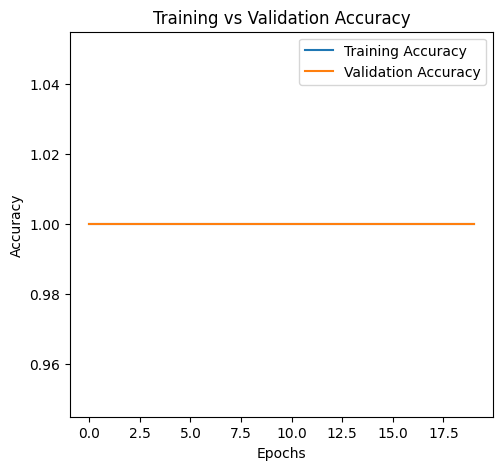

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

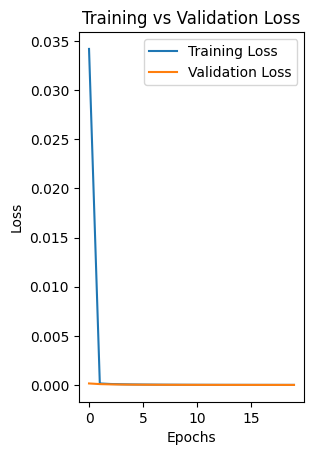

In [16]:
# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

**Evaluate Model**

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2149e-06
Test Accuracy: 1.00


**Predict Snoring**

In [18]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [19]:
y_pred

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    